## Thinkful Capstone Project - Analysis of Reported Crimes in Chicago from 2001 to 2019

#### Ilango Gopalan, December 2019



## Describe Dataset and story I'm trying to tell

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
import datetime
import time
import pyarrow
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.set_option('display.max_columns', 50)

## Exploring the Data

In [2]:
crimes = pd.read_csv(('Crimes_-_2001_to_present.csv.xz'))

C:\Users\ilang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
crimes.shape #7 million rows of reported crimes from 2001 to 2019, includes 22 features.

(7032560, 22)

### Features that will be converted OR dropped:

1. ID / Case Number / Domestic / X Coordinate / Y Coordinate / Updated On / Location - **DROPPED**
2. Date - from string to **datetime**
3. District / Ward / Community Area - from float to **integer**
4. IUCR - will remain as a string because there are multiple codes that include both letters and numbers

In [4]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032560 entries, 0 to 7032559
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.1+ GB


## Feature Conversion

### Date Modification

Currently, 'Date' is a string.  I will split 'Date' into
1. month, day, year
2. Time 
3. AM/PM

Then I will convert to the timestamps and create **3 columns**

In [5]:
crimes.Date[0] #Date column is a string

'01/01/2001 11:00:00 AM'

In [6]:
print(crimes.Date[0].split()) #Separating the string into date, time, AM/PM

['01/01/2001', '11:00:00', 'AM']


In [7]:
#Creating 3 new columns for crime event as date, time, and AM/PM
crimes['Crime_dates'] = crimes.Date.apply(lambda x: x.split()[0])
crimes['Crime_time'] = crimes.Date.apply(lambda x: x.split()[1])
crimes['Crime_AM_PM'] = crimes.Date.apply(lambda x: x.split()[2])

In [10]:
#converting the date and time strings to datetime
crimes.Crime_dates = pd.to_datetime(crimes.Crime_dates)
crimes.Crime_time = pd.to_datetime(crimes.Crime_time)

In [11]:
crimes.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Crime_dates,Crime_time,Crime_AM_PM
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,412,4.0,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN,2001-01-01,2019-12-26 11:00:00,AM


# Why does crime_time still include date, and wrong date at that???

## Data Cleaning

Other features cannot be converted until the **NaN and Null** values have been removed.  As shown below, there are only 2 features with NaN values comprising over 1% of the entire dataset - **Ward** and **Community Area**.  Since Ward and Community Area NaN values are still less than 10% of the entire dataset, AND are **categorical values**,  I am choosing to drop those records.

In [12]:
crimes.isnull().sum()*100/crimes.isnull().count()

ID                      0.000000
Case Number             0.000057
Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.085175
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000668
Ward                    8.742620
Community Area          8.723651
FBI Code                0.000000
X Coordinate            0.955925
Y Coordinate            0.955925
Year                    0.000000
Updated On              0.000000
Latitude                0.955925
Longitude               0.955925
Location                0.955925
Crime_dates             0.000000
Crime_time              0.000000
Crime_AM_PM             0.000000
dtype: float64

In [13]:
crimes = crimes[['Crime_dates', 'Crime_time', 'Crime_AM_PM', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description',
                'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude']]

In [14]:
crimes = crimes.dropna()

In [15]:
crimes.isnull().sum()

Crime_dates             0
Crime_time              0
Crime_AM_PM             0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
Year                    0
Latitude                0
Longitude               0
dtype: int64

### District / Ward / Community Area - from float to integer

In [16]:
crimes.District = crimes.District.astype(int)
crimes.Ward = crimes.Ward.astype(int)
crimes['Community Area'] = crimes['Community Area'].astype(int)

In [17]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6354634 entries, 60342 to 7032557
Data columns (total 17 columns):
Crime_dates             datetime64[ns]
Crime_time              datetime64[ns]
Crime_AM_PM             object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                int32
Ward                    int32
Community Area          int32
Year                    int64
Latitude                float64
Longitude               float64
dtypes: bool(2), datetime64[ns](2), float64(2), int32(3), int64(2), object(6)
memory usage: 715.1+ MB


## Data Exploration

### I want to display bar charts to compare total arrests vs. no arrests

### Groupby Year by the highest frequency of crimes, so Year by Theft; Year by Battery; then Year by Handgun

### Histogram 

### Scatter Plot of Latitude and Longitude

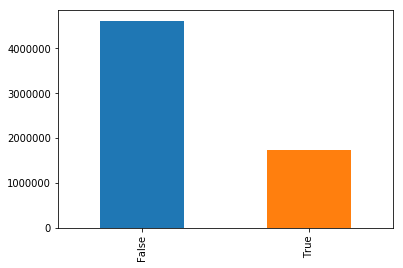

In [18]:
crimes.Arrest.value_counts().plot.bar()

In [19]:
crimes['Primary Type'].value_counts()

THEFT                                1348107
BATTERY                              1163057
CRIMINAL DAMAGE                       725918
NARCOTICS                             650511
ASSAULT                               399598
OTHER OFFENSE                         394470
BURGLARY                              364881
MOTOR VEHICLE THEFT                   288611
DECEPTIVE PRACTICE                    251666
ROBBERY                               240202
CRIMINAL TRESPASS                     182531
WEAPONS VIOLATION                      71486
PROSTITUTION                           60574
PUBLIC PEACE VIOLATION                 45852
OFFENSE INVOLVING CHILDREN             43042
CRIM SEXUAL ASSAULT                    25440
SEX OFFENSE                            22749
INTERFERENCE WITH PUBLIC OFFICER       16207
GAMBLING                               13355
LIQUOR LAW VIOLATION                   12200
ARSON                                  10185
HOMICIDE                                9630
KIDNAPPING

## Modeling

### What models should I use???

In [ ]:
#